# MD-Scan

This code provides an R implementation of the multi-dimensional scan (md-scan) algorithm

#### Set working directory and load libraries

In [1]:
setwd('/Users/williamogallo/ai-research/mdscan') #should be changed as needed
library(ggplot2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


#### Load sample dataset (Lalonde)
A data frame with 614 observations (185 treated, 429 control).
* treat : treatment assignment (1=treated, 0=control) <br> 
* age: age in year groups (0 = less than 25 years, 1 = 25 to 44 years, 2 = 45 years or more) <br>
* educ: education in years of schooling (0 = 0 to 5 years, 1 = 6 to 10 years, 2 = 10 to 15 years, 3 = 16 years or more) <br>
* black: indicator for African-American (1=African-American, 0=not) <br>
* hispan: indicator for being of Hispanic origin (1=Hispanic, 0=not) <br> 
* married: is an indicator for married (1=married, 0=not married) <br> 
* nodegree: is an indicator for whether the individual has a high school degree (1=no degree, 0=degree) <br> 
* re74: is income in 1974, in U.S. dollars (0 = less than 1000, 1 = 1001 to 10000, 2 = 10001 to 20000, 3 = more than 20000) <br>
* re75: is income in 1975, in U.S. dollars (0 = less than 1000, 1 = 1001 to 10000, 2 = 10001 to 20000, 3 = more than 20000)<br>
* re78: outcome variable, income in 1978, in U.S. dollars <br>

In [2]:
dat <- read.csv("lalonde.csv")
rownames(dat) <- dat$id
dat$id <-NULL

dat$age <-as.integer(ifelse(dat$age<25,0,
                           ifelse(dat$age<45,1,2)))

dat$educ <- as.integer(ifelse(dat$educ<=5,0,
                       ifelse(dat$educ<=10,1,
                              ifelse(dat$educ<=15,2,3))))

dat$re74 <- as.integer(ifelse(dat$re74<=1000,0,
                       ifelse(dat$re74<=10000,1,
                              ifelse(dat$re74<=20000,2,3))))


dat$re75 <- as.integer(ifelse(dat$re75<=1000,0,
                       ifelse(dat$re75<=10000,1,
                              ifelse(dat$re75<=20000,2,3))))
str(dat)
head(dat)

'data.frame':	614 obs. of  10 variables:
 $ treat   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ age     : int  1 0 1 1 1 0 0 1 0 1 ...
 $ educ    : int  2 1 2 2 1 1 2 2 3 2 ...
 $ black   : int  1 0 1 1 1 1 1 1 1 0 ...
 $ hispan  : int  0 1 0 0 0 0 0 0 0 0 ...
 $ married : int  1 0 0 0 0 0 0 0 0 1 ...
 $ nodegree: int  1 1 0 1 1 1 0 1 0 0 ...
 $ re74    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ re75    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ re78    : num  9930 3596 24909 7506 290 ...


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,1,2,1,0,1,1,0,0,9930.0460
NSW2,1,0,1,0,1,0,1,0,0,3595.8940
NSW3,1,1,2,1,0,0,0,0,0,24909.4500
NSW4,1,1,2,1,0,0,1,0,0,7506.1460
NSW5,1,1,1,1,0,0,1,0,0,289.7899
NSW6,1,0,1,1,0,0,1,0,0,4056.4940


#### Covariates, treatments, and outcome

In [3]:
covars <-c("age","educ", "black","hispan","married","nodegree","re74","re75")
treatment <-"treat"
outcome <-c("re78")

#### Print helper function

In [4]:
print_output <-function(title, output){
  cat("\n")
  cat("\n")
  print("___________________________________________________")
  print(title)
  print(output)
  print("___________________________________________________")
  cat("\n")
  cat("\n")
}

#### Generate features and feature values for covariates in dataset
@param covariates: vector of covariate names <br>
@param dat: the dataset<br>
@return: dataframe data frame listing features and feature values

In [5]:
get_feature_and_values<-function(covariates,dat){
  all_values<-lapply(covariates, function(x){
    v<-as.character(unique(dat[,x]))
    a<-rep(x,length(v))
    df<-data.frame(cbind(feature=a,value=v),stringsAsFactors = F)
  })
  df <- as.data.frame(do.call(rbind, all_values))
  return(df)
}
get_feature_and_values(covars,dat)

feature,value
age,1
age,0
age,2
educ,2
educ,1
educ,3
educ,0
black,1
black,0
hispan,0


#### Generate random subpopulation
@param features_values: data frame listing features and feature values <br>
@return dataframe with features and values of features for a given subpopulation

In [6]:
get_random_subpopulation<-function(features_values){
  n<-nrow(features_values)
  indexes<-sample(1:n,sample(1:n,1))
  subpopulation <-features_values[indexes,]
  subpopulation<-subpopulation[order(subpopulation$feature),]
  return(subpopulation)
}

#### Get subset of data for a random subpopulation
@param subgroup: data frame listing subgroup of features and feature values <br>
@param dat: the dataset <br>
@return subset of data for a given subpopulation

In [7]:
get_data_subset<-function(subgroup, dat){
  conditions<-c()
  for(feature in unique(subgroup$feature)){
    values<-subgroup[subgroup$feature == feature, "value"]
    str <- paste(feature, " %in% c(", paste(values, collapse=", "), ")", sep = "")
    conditions <-c(conditions, str)
  }
  conditions<-paste(conditions, collapse = " && ")
  data_subset<-subset(dat,eval(parse(text=conditions)))
  return(data_subset)
}

#### kolmogorov-smirnov plot
Source code from https://rpubs.com/mharris/KSplot

In [8]:
get_ks_plot <-function(treated_group, untreated_group, outcome){
    
    group <- c(rep("Treated", length(treated_group)), rep("Untreated", length(untreated_group)))
    dat <- data.frame(KSD = c(treated_group,untreated_group), group = group)
    
    # create ECDF of data
    cdf1 <- ecdf(treated_group) 
    cdf2 <- ecdf(untreated_group) 
    
    # find min and max statistics to draw line between points of greatest distance
    minMax <- seq(min(treated_group, untreated_group), max(treated_group, untreated_group), length.out=length(treated_group)) 
    x0 <- minMax[which( abs(cdf1(minMax) - cdf2(minMax)) == max(abs(cdf1(minMax) - cdf2(minMax))) )] 
    y0 <- cdf1(x0) 
    y1 <- cdf2(x0) 
    
    ggplot(dat, aes(x = KSD, group = group, color = group))+ 
    stat_ecdf(size=1) +
    theme(legend.position ="top") +
    xlab("Sample") +
    ylab("ECDF") +
    geom_segment(aes(x = x0[1], y = y0[1], xend = x0[1], yend = y1[1]), color = "black") +
    geom_point(aes(x = x0[1] , y= y0[1]), color="black", size=4) +
    geom_point(aes(x = x0[1] , y= y1[1]), color="black", size=4) +
    ggtitle(paste("K-S Divergence in ",outcome," among Treated vs Untreated", sep="")) +
    theme(legend.title=element_blank(), plot.title = element_text(size = 14, face = "bold",hjust = 0.5))+
    theme(axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))
    
}


#### Score function
@param dat: dataset <br>
@return Kolmogorov–Smirnov test measure of divergence

In [9]:
get_divergence_score <- function(treatment, outcome, dat){

  #get ks samples
  trt<-dat[,treatment]
  treated_group <- dat[,outcome][trt==1]
  untreated_group <- dat[,outcome][trt==0]
    
  if(length(treated_group)<30 | length(untreated_group)<30)
      return(NULL)
  
  #ks test
  options(warn=-1)
  ks <-ks.test(treated_group, untreated_group)
  options(warn=0)
    
  #plot ks
  print(get_ks_plot(treated_group, untreated_group, outcome))
  
  return(round(ks$statistic,4))
}

#### Priority Function
@param feature: Discrete feature name e.g. Gender or Age <br> 
@param feature_value_df: data frame of covariate feature values to condition on <br>
@param dat: dataset to be scanned <br>
@return ranking of feature values

In [10]:
get_priority_score <- function(feature, feature_value_df,  treatment, outcome, dat){
  
  #create feature_value_priority_df
  feature_value_priority_df <- data.frame(feature_value_df[feature_value_df$feature==feature,which(colnames(feature_value_df) %in% c("feature","value"))],stringsAsFactors = F)
  
  #compute priority score for each feature value and store as column in feature_value_priority_df
  feature_value_priority_df$priority_score<-sapply(feature_value_priority_df$value, function(value){
    #get subset of feature value population
    str<-paste("dat$",feature," == ",value, sep="")
    dat2<-dat[eval(parse(text=str)),]
    
    # compute priority scores
    trt<-dat2[,treatment]
    treated_group <- dat2[,outcome][trt==1]
    untreated_group <- dat2[,outcome][trt==0]
    
    if(is.null(treated_group)| is.null (untreated_group)){
         return(NULL)
    } else{
       priority_score <- round(mean(treated_group)/mean(untreated_group),3)
       return(priority_score) 
    }
  })
  
  #remove nulls
  feature_value_priority_df <-na.omit(feature_value_priority_df)
  #order feature_value_priority_df by priority score
  feature_value_priority_df<-feature_value_priority_df[order(feature_value_priority_df$priority_score, decreasing = T),]
  
  return(feature_value_priority_df)
}

#### Highest scoring subset
@param feature: Discrete feature name e.g. Gender or Age <br>
@param priority_df: data frame of feature value priority <br>
@param dat: dataset to be scanned <br>
@return highest scoring subset of values for the feature

In [11]:
get_highest_scoring_subset <- function(feature, priority_df, treatment, outcome, dat){
  #Initialize parameters
  best_score <-10^-10
  best_subset<-c()
  subset<-c()
  for(i in 1:nrow(priority_df)){
    subset[i]<-as.numeric(as.character(priority_df$value[i]))

    str<-paste("dat$",feature, " %in% c(", paste(subset, collapse=", "), ")", sep = "")
    dat2<-dat[eval(parse(text=str)),]
    
    score<- get_divergence_score(treatment, outcome, dat2)
    print_output("Current score",score)
    if(!is.null(score) && score > best_score){
      best_score <- score
      best_subset <- data.frame(cbind(feature = rep(feature, length(subset)), value = subset),stringsAsFactors = F)
    }
  }
  return(best_subset)
}

#### Update feature values
@param feature_value_df: data frame of covariate feature values <br>
@highest_scoring_subset: highest scoring subset of values for a given feature <br>
@return updated feature_value_df based on highest scoring subset for a given feature

In [12]:
update_feature_value_df<- function(feature_value_df, highest_scoring_subset){
  update_condition <-paste(feature_value_df$feature, feature_value_df$value) %in% paste(highest_scoring_subset$feature, highest_scoring_subset$value)
  feature_value_df$condition_on[update_condition]<-1
  return(feature_value_df)
}

#### MDSS
@param feature: Discrete feature name e.g. Gender or Age <br> 
@param feature_value_df: data frame of covariate feature values to condition on <br>
@param dat: dataset to be scanned <br>
@return Updated feature_value_df based on highest scoring subset for a given feature

In [13]:
mdss<-function(feature, feature_value_df, treatment, outcome, dat){
  
  #compute priority for all feature value
  feature_value_priority_df <- get_priority_score(feature, feature_value_df, treatment, outcome, dat)
  print_output("Feature value priority scores",feature_value_priority_df)

  #identify highest scoring subset of the feature
  highest_scoring_subset <- get_highest_scoring_subset(feature,feature_value_priority_df, treatment, outcome, dat)
  print_output("Highest scoring subset",highest_scoring_subset)

  #update feature_value_df based on highest_scoring_subset
  feature_value_df<-update_feature_value_df(feature_value_df, highest_scoring_subset)

  #return updated feature_value_df
  return(feature_value_df)
}

#### MD-Scan
@param covars: vector of covariate column names <br> 
@param treatment: column name of a single treatment/intevention <br> 
@param outcome: column name of a single outcome <br>
@param dat: the data set to be scanned <br>
@return highest scoring subset of feature values

In [14]:
mdscan<-function(covars, treatment, outcome, dat){
  
  #0_ get features and feature_values
  feature_value_df <- get_feature_and_values(covars,dat)
  print_output("Initial feature value data frame",feature_value_df)
    
  #Initialize params
  best_overal_score <- 10^-10
  best_overal_subset <-c()
  i<-1
  
  #initialize cur_subgroup
  cur_subgroup<-get_random_subpopulation(feature_value_df)
  print_output("initial cur_subgroup",cur_subgroup)
  
  #initial list of features
  features<-unique(feature_value_df$feature)
  
  #get current dataset given cur_subgroup
  cur_data_subset<-get_data_subset(cur_subgroup,dat)
  print_output("Initial cur_data_subset head",head(cur_data_subset))
  
  while(TRUE) {
    #Track iteration
    print_output("Current Iteration (i)",i)
    
    #Initialize params
    best_score <- 10^-10
    best_subset <-c()
    feature_value_df$condition_on <-1
    
    #1.Randomly order the m features to scan from 1 to M
    features <-sample(features)
    print_output("Random order of m features",features)
    
    current_score<-10^-11
    
    for(feature in features){
      print_output("Current feature", feature)
      
      #1.cur_data_subset = Data|cur_subgroup-j (relax subgroup definition to include all values of feature j)
      feature_value_df[feature_value_df$feature==feature,"condition_on"] <-0 
      print_output("Updated feature value data frame", feature_value_df)
      
      cur_data_subset<- get_data_subset(feature_value_df[feature_value_df$condition_on==1,],dat)
      print_output("cur_data_subset head",head(cur_data_subset))
      
      #2.Cur_subgroup = MDSS(cur_data_subset) (Use MDSS on cur_dataset to identify the exact highest scoring subset of values of feature j, given cur_subgroup-j)
      feature_value_df<- mdss(feature,feature_value_df, treatment, outcome, cur_data_subset)
      cur_subgroup <-feature_value_df[feature_value_df$condition_on==1,]
      
      #3. Cur_data_subset = Data|cur_subgroup
      cur_data_subset<- get_data_subset(cur_subgroup,dat)
      
      #4. Best_score = score(cur_data_subset)
      current_score <- get_divergence_score(treatment, outcome,cur_data_subset)
      
      if(!(is.null(current_score)) && current_score > best_score){
        best_score <- current_score
        best_subset<- cur_subgroup
      }
    }
    
    #Check end condition, else loop through features in random order again
    if (best_score <= best_overal_score) break
    
    best_overal_score = best_score
    best_overal_subset = best_subset
    
    i <- i + 1
    
  }
  
  return(list(best_overal_score, best_overal_subset))
  
}



[1] "___________________________________________________"
[1] "Initial feature value data frame"
    feature value
1       age     1
2       age     0
3       age     2
4      educ     2
5      educ     1
6      educ     3
7      educ     0
8     black     1
9     black     0
10   hispan     0
11   hispan     1
12  married     1
13  married     0
14 nodegree     1
15 nodegree     0
16     re74     0
17     re74     1
18     re74     2
19     re74     3
20     re75     0
21     re75     1
22     re75     2
23     re75     3
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "initial cur_subgroup"
    feature value
9     black     0
5      educ     1
15 nodegree     0
18     re74     2
21     re75     1
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Initial cur_data_subset head"
 [1] treat    age      educ     black    hispan   married  

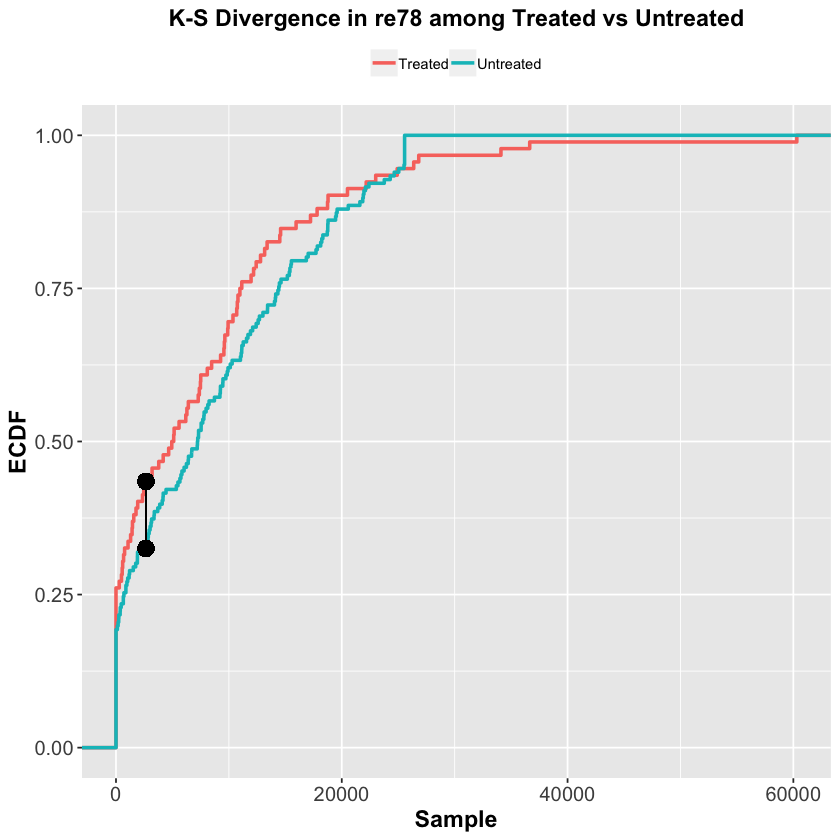



[1] "___________________________________________________"
[1] "Current score"
     D 
0.0897 
[1] "___________________________________________________"




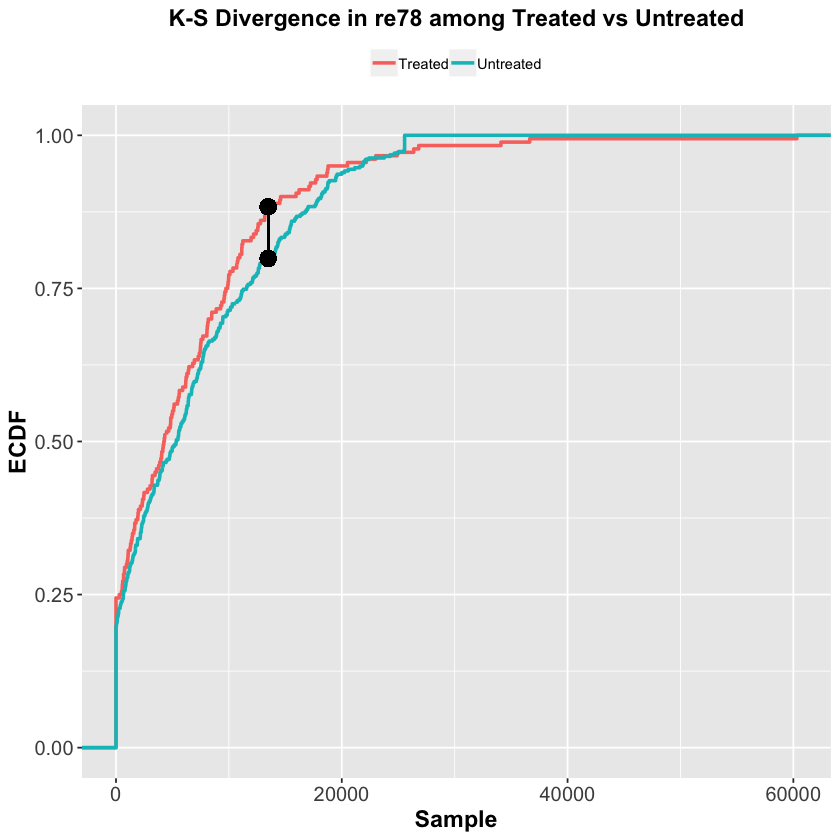



[1] "___________________________________________________"
[1] "Current score"
     D 
0.0986 
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Highest scoring subset"
  feature value
1     age     1
[1] "___________________________________________________"




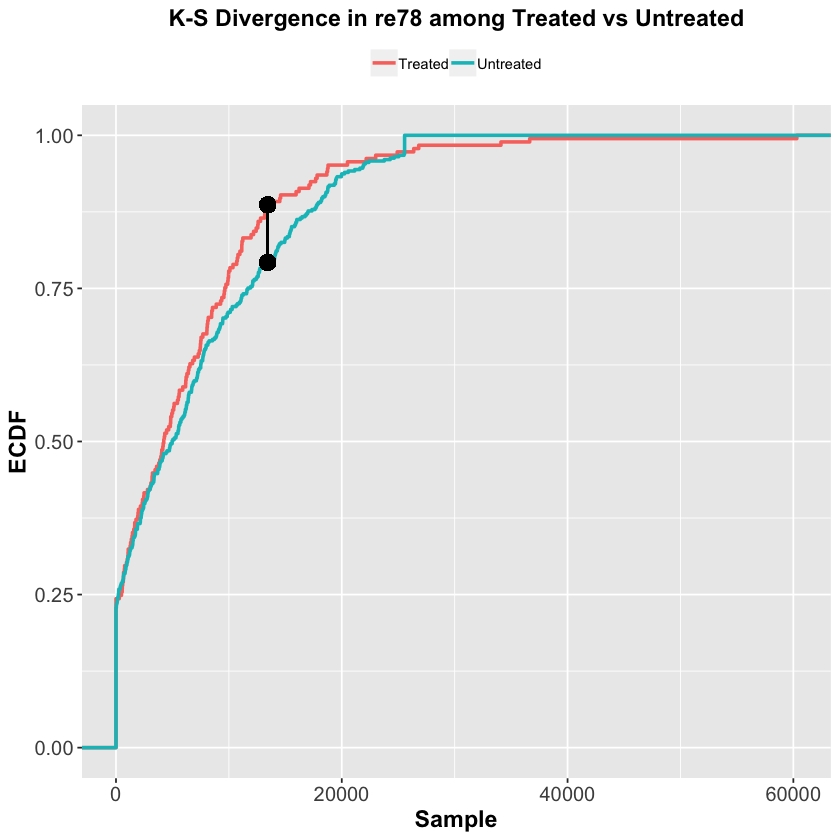



[1] "___________________________________________________"
[1] "Current feature"
[1] "re75"
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Updated feature value data frame"
    feature value condition_on
1       age     1            1
2       age     0            0
3       age     2            0
4      educ     2            1
5      educ     1            1
6      educ     3            1
7      educ     0            1
8     black     1            1
9     black     0            1
10   hispan     0            1
11   hispan     1            1
12  married     1            1
13  married     0            1
14 nodegree     1            1
15 nodegree     0            1
16     re74     0            1
17     re74     1            1
18     re74     2            1
19     re74     3            1
20     re75     0            0
21     re75     1            0
22     re75     2            0
23     re75     3            0
[1] 

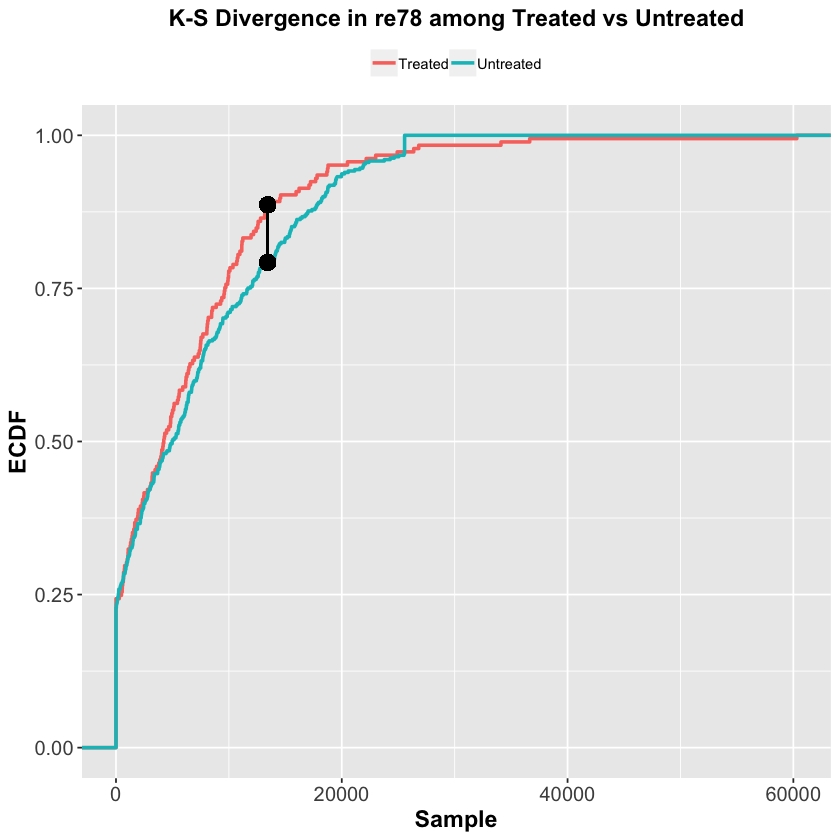



[1] "___________________________________________________"
[1] "Current score"
     D 
0.0584 
[1] "___________________________________________________"




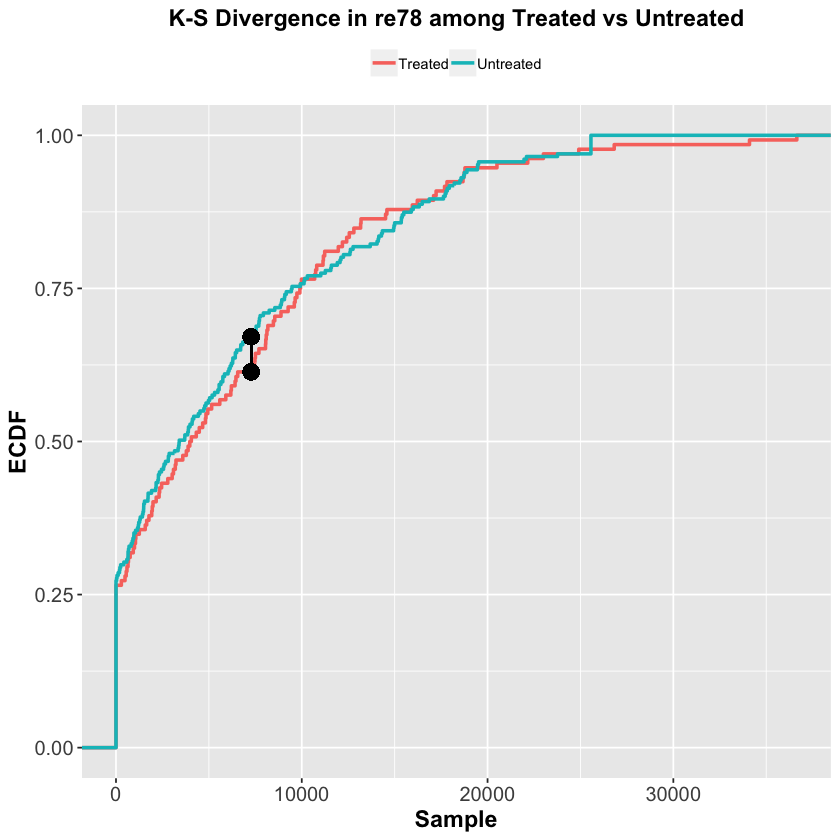



[1] "___________________________________________________"
[1] "Current score"
    D 
0.098 
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Highest scoring subset"
  feature value
1    re75     2
2    re75     0
3    re75     1
[1] "___________________________________________________"




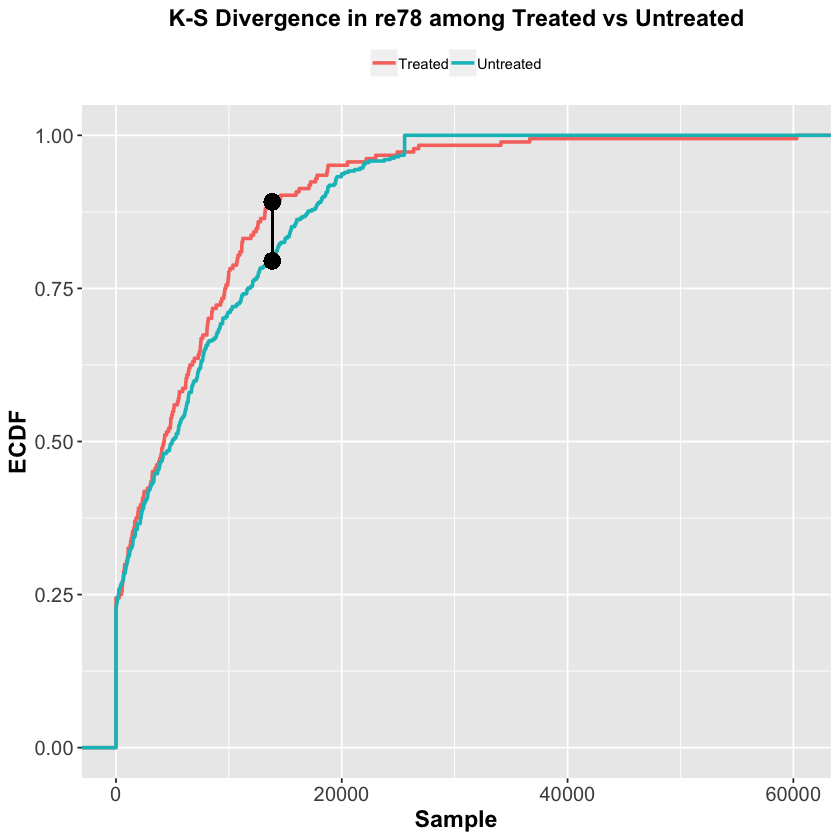



[1] "___________________________________________________"
[1] "Current feature"
[1] "hispan"
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Updated feature value data frame"
    feature value condition_on
1       age     1            1
2       age     0            0
3       age     2            0
4      educ     2            1
5      educ     1            1
6      educ     3            1
7      educ     0            1
8     black     1            1
9     black     0            1
10   hispan     0            0
11   hispan     1            0
12  married     1            1
13  married     0            1
14 nodegree     1            1
15 nodegree     0            1
16     re74     0            1
17     re74     1            1
18     re74     2            1
19     re74     3            1
20     re75     0            1
21     re75     1            1
22     re75     2            1
23     re75     3            0
[1

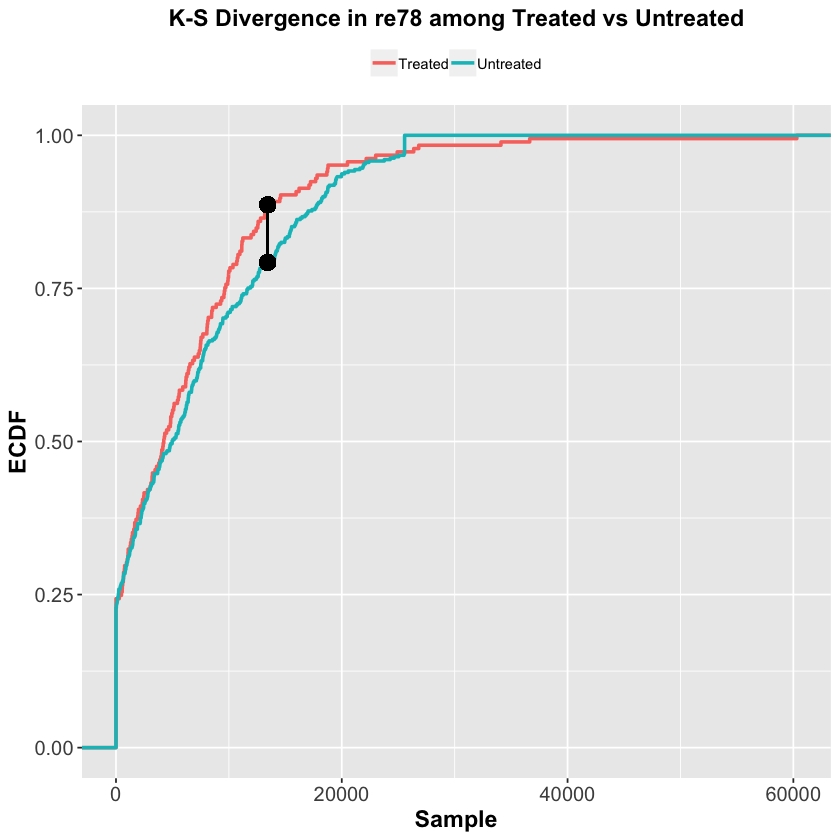



[1] "___________________________________________________"
[1] "Current score"
     D 
0.0986 
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Highest scoring subset"
  feature value
1  hispan     1
2  hispan     0
[1] "___________________________________________________"




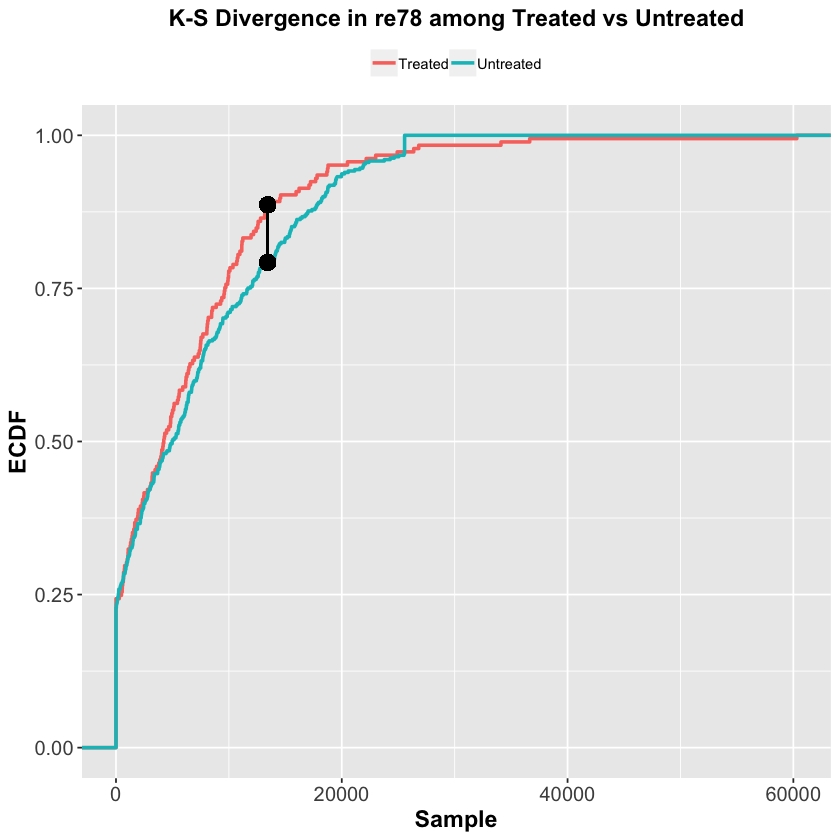



[1] "___________________________________________________"
[1] "Current feature"
[1] "nodegree"
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Updated feature value data frame"
    feature value condition_on
1       age     1            1
2       age     0            0
3       age     2            0
4      educ     2            1
5      educ     1            1
6      educ     3            1
7      educ     0            1
8     black     1            1
9     black     0            1
10   hispan     0            1
11   hispan     1            1
12  married     1            1
13  married     0            1
14 nodegree     1            0
15 nodegree     0            0
16     re74     0            1
17     re74     1            1
18     re74     2            1
19     re74     3            1
20     re75     0            1
21     re75     1            1
22     re75     2            1
23     re75     3            0


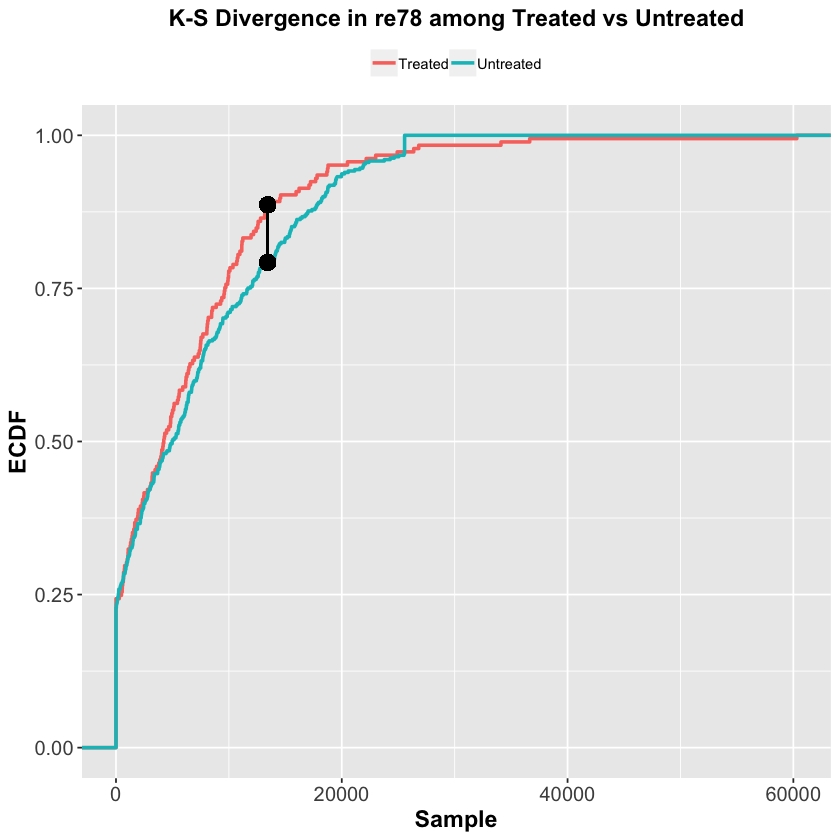



[1] "___________________________________________________"
[1] "Current score"
     D 
0.1084 
[1] "___________________________________________________"




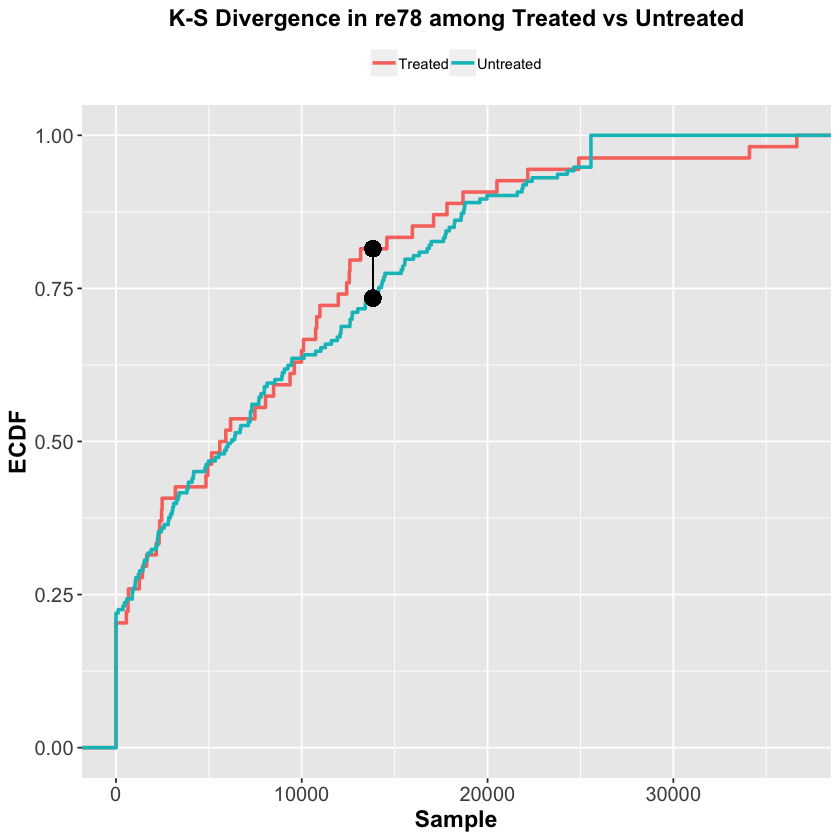



[1] "___________________________________________________"
[1] "Current score"
     D 
0.0986 
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Highest scoring subset"
   feature value
1 nodegree     0
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Current feature"
[1] "educ"
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Updated feature value data frame"
    feature value condition_on
1       age     1            1
2       age     0            0
3       age     2            0
4      educ     2            0
5      educ     1            0
6      educ     3            0
7      educ     0            0
8     black     1            1
9     black     0            1
10   hispan     0            1
11   hispan     1            1
12  married     1            1
13  ma

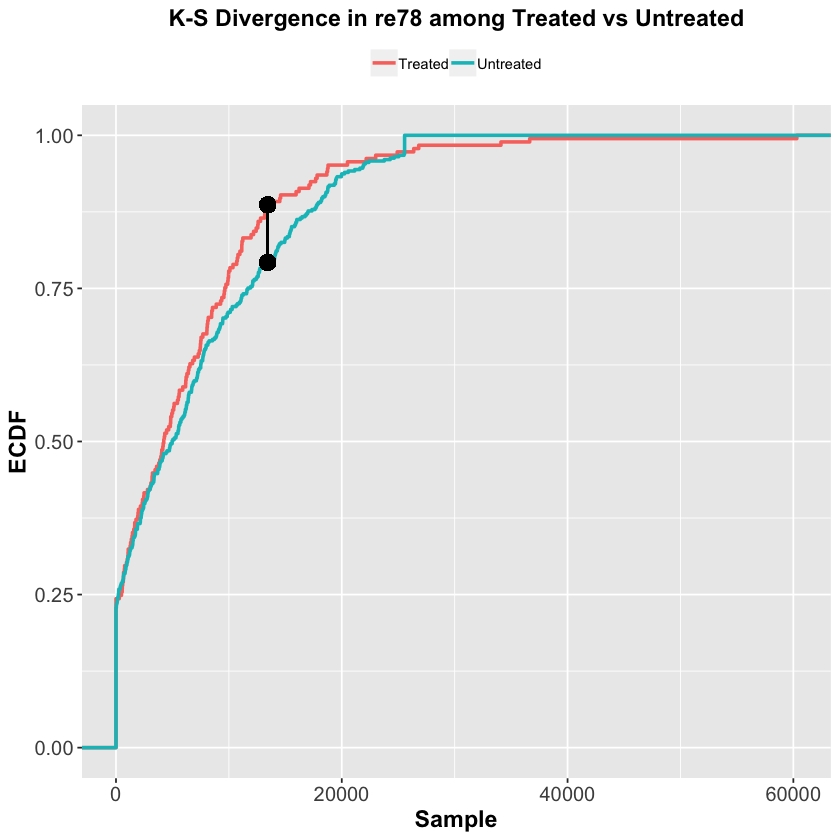



[1] "___________________________________________________"
[1] "Current score"
     D 
0.1084 
[1] "___________________________________________________"




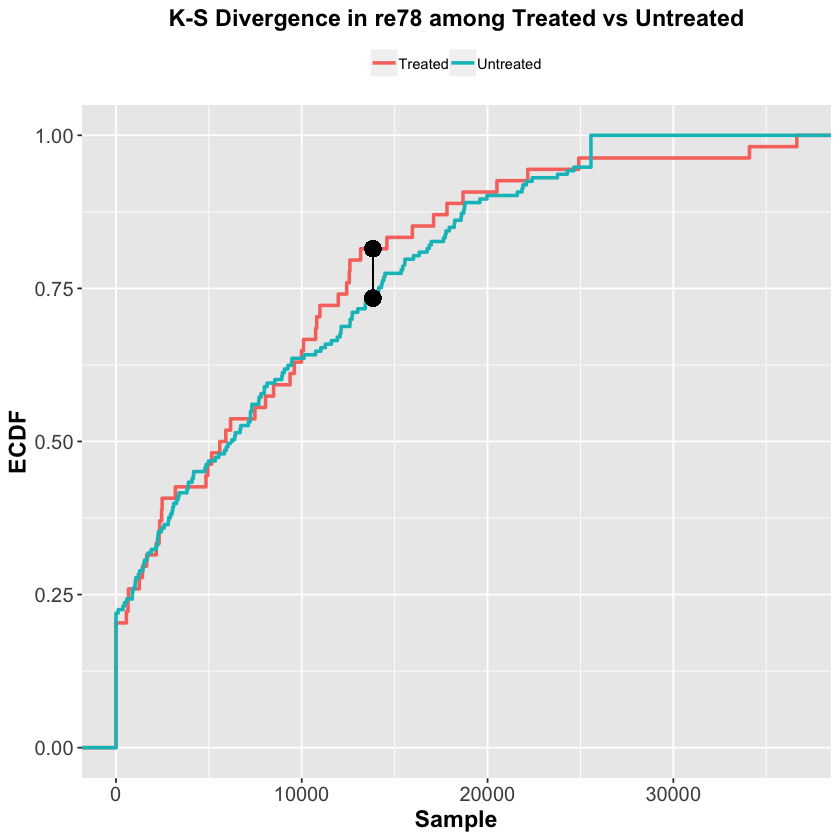



[1] "___________________________________________________"
[1] "Current score"
     D 
0.0986 
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Highest scoring subset"
   feature value
1 nodegree     0
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Current feature"
[1] "educ"
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Updated feature value data frame"
    feature value condition_on
1       age     1            1
2       age     0            1
3       age     2            1
4      educ     2            0
5      educ     1            0
6      educ     3            0
7      educ     0            0
8     black     1            1
9     black     0            1
10   hispan     0            1
11   hispan     1            1
12  married     1            1
13  ma

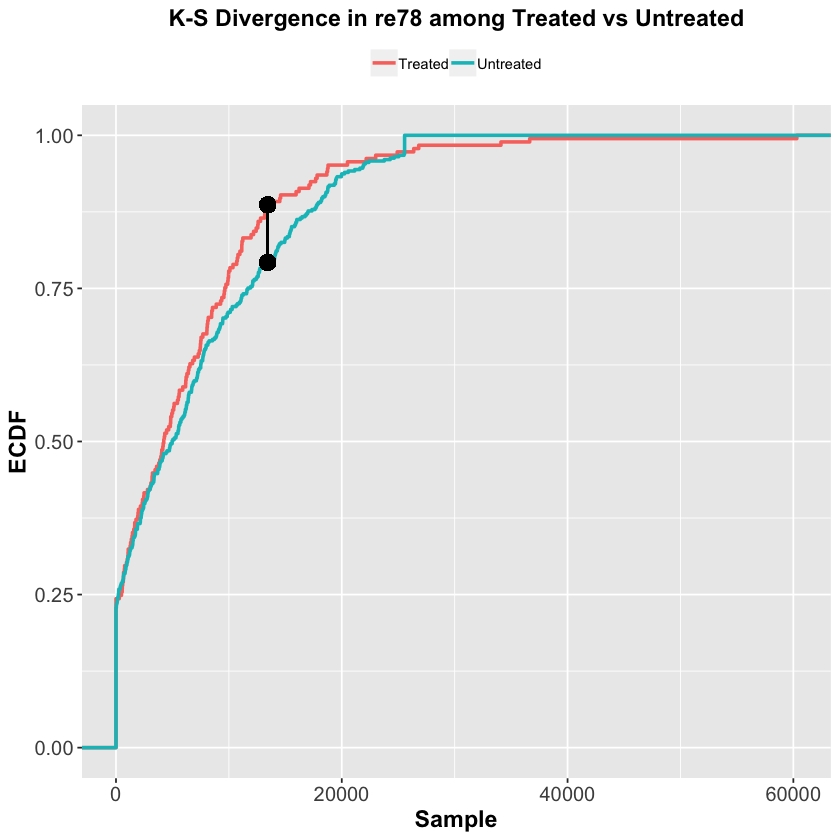



[1] "___________________________________________________"
[1] "Current score"
     D 
0.1112 
[1] "___________________________________________________"




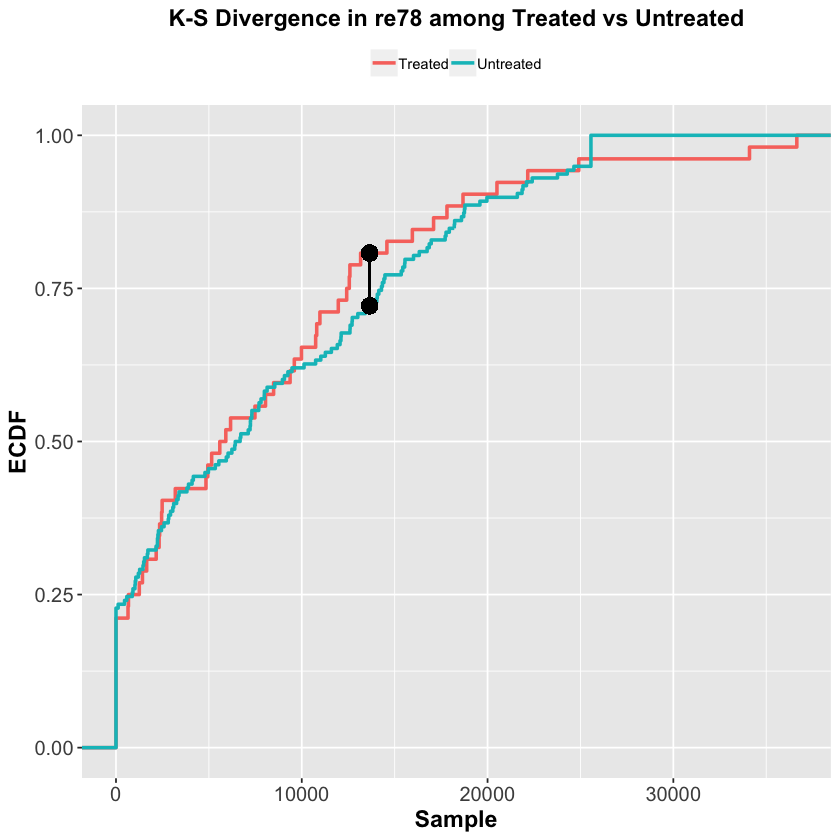



[1] "___________________________________________________"
[1] "Current score"
     D 
0.1084 
[1] "___________________________________________________"




[1] "___________________________________________________"
[1] "Highest scoring subset"
  feature value
1  hispan     0
[1] "___________________________________________________"




,feature,value,condition_on
1,age,1,1
4,educ,2,1
5,educ,1,1
6,educ,3,1
7,educ,0,1
8,black,1,1
9,black,0,1
10,hispan,0,1
11,hispan,1,1
12,married,1,1


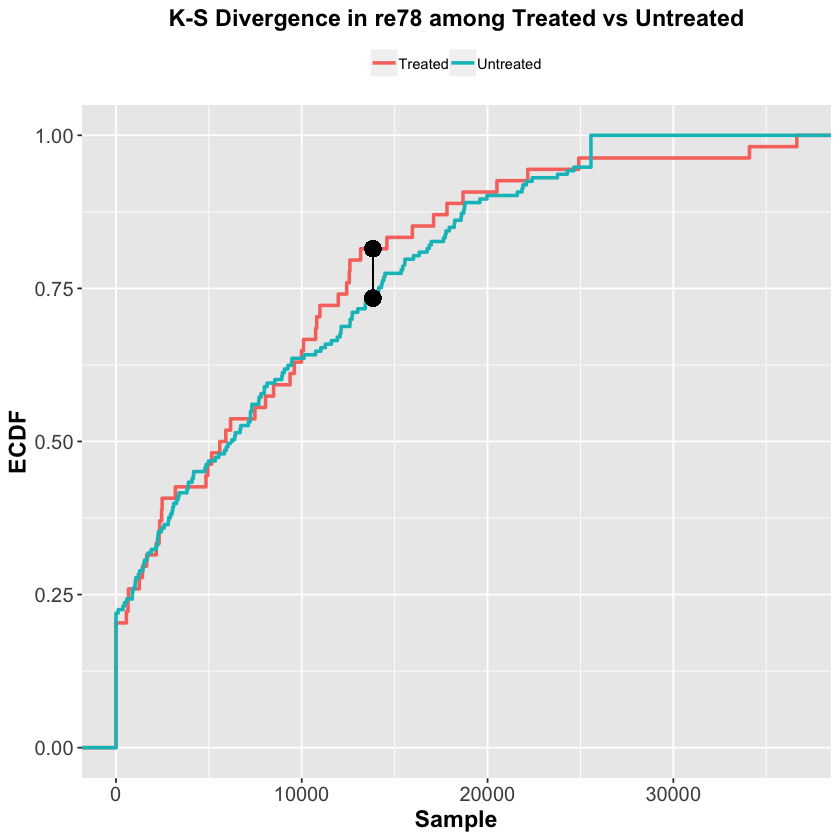

In [15]:
mdscan(covars,treatment,outcome, dat)